Systematic Uncertainty Modelling
===

In the `Neural_Likelihood_Ratio_Estimation.ipynb` notebook, we left out the nuisance parameter piece of the parameterized density ratio decomposition:

$$g_c(x|\alpha) = \frac{p_c(x|\alpha)}{p_c(x)} = \prod_m \frac{p_c(x|\alpha_m^{eval})}{p_c(x)}$$

where the second equality assumes that the effect of various sources of uncertainty in the model can be factorized. This is another density ratio estimation problem, but instead of training m $\alpha-$parameterized NNs, we use a HistFactory-style interpolation generalized to a per-event formulation:

$$\frac{p_c(x|\alpha_m^{eval})}{p_c(x)} = \begin{cases}
    \left(\frac{p_c(x|\alpha_m^+)}{p_c(x)}\right)^{\alpha_m^\text{eval}}& \alpha_m^\text{eval}>1\\
    1+\sum_{n=1}^6c_n\cdot (\alpha_m^\text{eval})^n& -1\leq\alpha_m^\text{eval}\leq 1\\
    \left(\frac{p_c(x|\alpha_m^-)}{p_c(x)}\right)^{-\alpha_m^\text{eval}}& \alpha_m^\text{eval}<-1\\
    \end{cases}$$

where $\alpha=\{\alpha_m^{eval}\}$ and for each nuisance parameter $m$, we have three simulation models - $p_c(x), p_c(x|\alpha_m^+), p_c(x|\alpha_m^-)$. Naturally, this still requires NNs to estimate the density ratios:

$$\frac{p_c(x|\alpha_m^+)}{p_c(x)} \, , \frac{p_c(x|\alpha_m^-)}{p_c(x)}$$

**These are the density ratios that we will estimate using NNs in this notebook.**
Two ratios corresponding to each $\alpha_m^\pm$ will be trained for each systematic uncertainty indexed by $m$ and for each channel $c$ to build the final parameterized model, 

$$\frac{p(x|\mu, \alpha)}{p_{ref}(x)} = \frac{1}{\sum_c G_c(\alpha) \cdot f_c(\mu) \cdot \nu_c} \sum_c f_c(\mu) \cdot G_c(\alpha) \cdot \nu_c \cdot g_c(x|\alpha) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)}$$

The full workflow for building $\mu, \alpha-$parameterized density ratios is represented in the flowchart below:

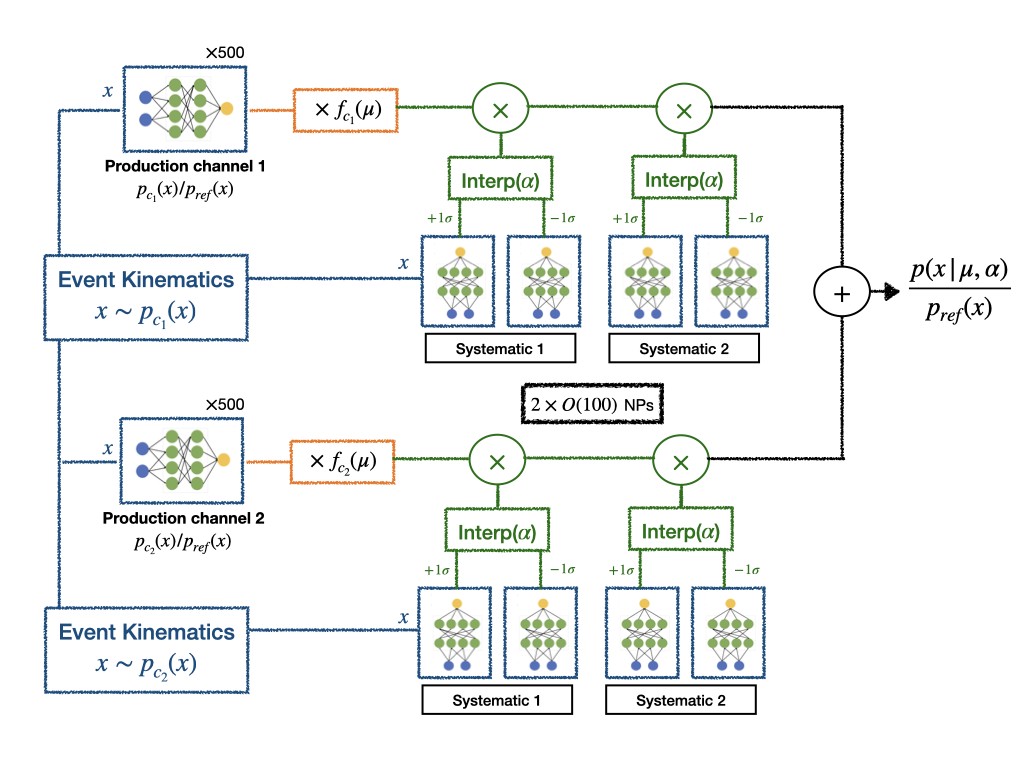

In [1]:
import os, sys, importlib
sys.path.append('../')

import common_utils
from common_utils import plotting, training
from common_utils.training import TrainEvaluate_NN, TrainEvaluatePreselNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.optimizers import Nadam
import mplhep as hep
import matplotlib.pyplot as plt
import pickle

from coffea.analysis_tools import PackedSelection

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

hep.style.use(hep.style.ATLAS)

/data/jaySandesara/NSBI_workflow_tutorial/cms_ttbar_open_data/../common_utils/plotting.py:10: FutureWarning: ``set_style`` is deprecated: Naming convention is changing to match mpl. Use ``mplhep.style.use()``.
  hep.set_style("ATLAS")
2025-05-08 11:27:32.380152: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-08 11:27:33.019933: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Load the datasets from pre-processed input
saved_data='./cached_data/'

syst_labels = np.load(f"{saved_data}syst_labels.npy")
training_features = np.load(f"{saved_data}features.npy")
train_labels = np.load(f"{saved_data}train_labels.npy")
weights = np.load(f"{saved_data}weights.npy")

# List of systematics to include
list_syst = ['ttbar_scale']

# Which samples are affected by which systematics
dict_systs = {'ttbar_scale': ['ttbar']}

list_syst = [key for key in dict_systs]


In [3]:
np.unique(syst_labels)

array(['ME_var', 'PS_var', 'nominal', 'pt_res_up', 'pt_scale_up',
       'ttbar_scale_down', 'ttbar_scale_up'], dtype='<U16')

In [4]:
# Keep only a subset of the background for illustration
labels_dict = {"ttbar": 0,              # signal process
              "single_top_t_chan":1, 
              "wjets":2}

# Uncomment below for a full analysis with all backgrounds
# labels_dict = {"ttbar": 0,
#                "single_top_s_chan":1,
#               "single_top_t_chan":2,
#               "single_top_tW":3,
#               "wjets":4}

In [5]:
type_vec = np.array(train_labels, dtype='object')

for key in labels_dict:
    type_vec[type_vec==labels_dict[key]] = key


In [6]:
# Build a pandas dataframe from the arrays for density ratio training and validation
# columns = ['lepton_pt', 'lepton_eta', 'lepton_phi']
columns = ['lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T', 'n_jets']
dataset_incl = pd.DataFrame(training_features, columns=columns)

# Some scaling to reduce the spread of pt distributions 
dataset_incl['log_lepton_pt'] = np.log(dataset_incl['lepton_pt'].ravel())
dataset_incl['log_H_T'] = np.log(dataset_incl['H_T'].ravel())
dataset_incl['type'] = type_vec
dataset_incl['syst_labels'] = syst_labels
dataset_incl['weights'] = weights

Preselecting the systematics samples
===

In [7]:
# Only use lepton kinematics - use log pT for reduced spread
columns = ['log_lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T', 'n_jets']
columns_scaling = ['log_lepton_pt', 'lepton_eta', 'lepton_phi', 'H_T']

# # Use lepton kinematics and the sum of jet pT observable 
# columns = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi']
# columns_scaling = ['log_lepton_pt', 'log_H_T', 'lepton_eta', 'lepton_phi'] # Subset of features which need scaling

In [8]:
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluatePreselNN

preselectionTraining = TrainEvaluatePreselNN(dataset_incl, columns, columns_scaling)

In [9]:
path_to_saved_presel_model = './preselection_saved_NN/'
USE_SAVED_MODEL_PRESEL=True

preselectionTraining.get_trained_model(path_to_saved_presel_model)

2025-05-08 11:27:37.561121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1924 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.5gb, pci bus id: 0000:c1:00.0, compute capability: 8.0


In [10]:
# Get predictions (softmax outputs)
pred_NN = preselectionTraining.predict(dataset_incl)

   168/203270 [..............................] - ETA: 3:04

2025-05-08 11:27:38.193545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


203270/203270 [==============================] - 125s 612us/step


In [11]:
# the preselection score as defined above - log(P_S/P_B)
presel_score = np.log(pred_NN[:, labels_dict["ttbar"]]/(pred_NN[:, labels_dict["single_top_t_chan"]] + pred_NN[:, labels_dict["wjets"]]))

In [12]:
# preselection cut - same as training notebook
preselection_cut_lower = -0.6 

Signal and Control Regions
===

Split the dataset into SR and CR - the SR needs additional density ratios to be trained, whereas the CR follows the standard procedure of template histogram building.

In [13]:
# Make the preselections - defined the Signal Region

dataset_incl['presel_score'] = presel_score

dataset_SR = dataset_incl[(dataset_incl.presel_score>=preselection_cut_lower)].copy()
dataset_CR = dataset_incl[(dataset_incl.presel_score < preselection_cut_lower)].copy()

# Uncomment the line below if an upper cut is also needed
# dataset = dataset_incl[(dataset_incl.presel_score>=preselection_cut_lower) & (dataset_incl.presel_score<=preselection_cut_upper)].copy()

# Additional selections - same as nominal training notebook
dataset_SR = dataset_SR[(dataset_SR.lepton_pt<=200.0)].copy()
dataset_SR = dataset_SR[(dataset_SR.H_T<=1000.0)].copy()


In [14]:
# Load the Control Region observable
with open(f"{saved_data}hist_CR_ttbar.pkl", "rb") as fp:
    hist_CR = pickle.load(fp)


# Build variation template histograms for Control Region
num_bins = 5
min_presel_bin = -0.9
min_presel_bin = -7
max_presel_bin = preselection_cut_lower

bins = np.linspace(min_presel_bin, max_presel_bin, num = num_bins)

hist_var = {}

for process in labels_dict:
    
    hist_var[process] = {}
    mask_process = (dataset_CR.type==process)
    
    for syst in dict_systs:

        hist_var[process][syst] = {}

        for direction in ['up', 'down']:

            hist_var[process][syst][direction] = {}
        
            if process not in dict_systs[syst]:
                hist_var[process][syst][direction] = np.ones_like(hist_CR[process])

            else:
                mask_syst = (dataset_CR.syst_labels==syst+'_'+direction)
                mask_syst_process = mask_process & mask_syst
                
                hist_var[process][syst][direction] = np.histogram(np.clip(dataset_CR[mask_syst_process]['presel_score'].ravel(), 
                                                                    min_presel_bin, max_presel_bin), 
                                                                    weights = dataset_CR[mask_syst_process]['weights'].ravel(),
                                                                    bins = bins)[0]/hist_CR[process]

print(hist_var)

{'ttbar': {'ttbar_scale': {'up': array([1.03828172, 0.95089622, 0.9903286 , 0.97864447]), 'down': array([0.99335628, 0.98459558, 1.02108377, 1.04935215])}}, 'single_top_t_chan': {'ttbar_scale': {'up': array([1., 1., 1., 1.]), 'down': array([1., 1., 1., 1.])}}, 'wjets': {'ttbar_scale': {'up': array([1., 1., 1., 1.]), 'down': array([1., 1., 1., 1.])}}}


In [15]:
# Save the Control Region variation histogram
with open(f"{saved_data}hist_CR_variations.pkl", "wb") as fp:
    pickle.dump(hist_var, fp)

In [16]:
# Normalizing the training weights post preselection 
weights_normed      = dataset_SR['weights'].to_numpy().copy()
weights             = dataset_SR['weights'].to_numpy().copy()

for syst_sample in np.unique(syst_labels):

    mask_syst = dataset_SR.syst_labels==syst_sample
    
    for key in labels_dict:

        mask_syst_process                     = mask_syst & (dataset_SR.type==key)
        weights_normed[mask_syst_process]    /= weights[mask_syst_process].sum()

dataset_SR['weights_normed'] = weights_normed

Density ratio training
===

Now we train the NNs for $\frac{p_c}{p_{ref}}(x)$ density ratios to build the full model. Our choice of reference hypothesis, motivated by the search-oriented mixture model described above, is: 

$$p_{ref}(x) = p_\text{ttbar}(x) = \frac{1}{\nu_\text{ttbar}} \frac{d\sigma_\text{ttbar}}{dx} $$

gives the POI $\mu-$parameterized model:

$$\sum_c \left[f_c(\mu) \cdot \frac{p_c\left(x\right)}{p_{ref}(x)} \right]= \mu + \frac{p_\text{wjets}\left(x\right)}{p_\text{ttbar}(x)} + \frac{p_\text{single top}\left(x\right)}{p_\text{ttbar}(x)}$$

The task of estimating the $\mu-$parameterized density ratio is thus reduced to estimating two $\mu-$independent density ratios $\frac{p_\text{single top}}{p_{t\bar{t}}}(x)$ and $\frac{p_\text{wjets}}{p_{t\bar{t}}}(x)$ mixed together with an analytical parameterization (hence the name mixture model).

In [34]:
importlib.reload(sys.modules['common_utils.training'])
from common_utils.training import TrainEvaluate_NN

dataset_syst_process = {}
NN_training_syst_process = {}

rnd_seed_traintestsplit = 42 # can also be randomized, fixed for now

for process in labels_dict:
    
    NN_training_syst_process[process] = {}

    mask_process = (dataset_SR.type==process)
    
    for syst in dict_systs:

        if process not in dict_systs[syst]:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
            
        NN_training_syst_process[process][syst] = {}
        
        for direction in ['up', 'down']:

            # Save paths
            top_path = f'./output_training_systematics/'
            output_name = f'{process}_{syst}_{direction}'
            output_dir = f'{top_path}general_output_{process}_{syst}_{direction}'
            path_to_ratios = f'{top_path}output_ratios_{process}_{syst}_{direction}/'
            path_to_figures = f'{top_path}output_figures_{process}_{syst}_{direction}/'
            path_to_models = f'{top_path}output_model_params_{process}_{syst}_{direction}/'
            
            mask_process_syst = (dataset_SR.syst_labels==syst+'_'+direction) & mask_process
            mask_nominal = (dataset_SR.syst_labels=='nominal') & mask_process

            # Build a training dataset for the training of p_<process_type>/p_<ref_processes> density ratio
            dataset_syst_process = pd.concat([dataset_SR[mask_process_syst].copy(), 
                                                            dataset_SR[mask_nominal].copy()])

            mask_num_hypothesis = (dataset_syst_process.syst_labels==syst+'_'+direction)
            dataset_syst_process['train_labels'] = 0
            dataset_syst_process.loc[mask_num_hypothesis, 'train_labels'] = 1
            
            NN_training_syst_process[process][syst][direction] = TrainEvaluate_NN(dataset_syst_process, 
                                                                                   dataset_syst_process['weights_normed'],
                                                                                   dataset_syst_process['train_labels'],
                                                                                   columns, 
                                                                                   columns_scaling, rnd_seed_traintestsplit,
                                                                                   [syst+'_'+direction, process], output_dir, output_name, 
                                                                                    path_to_figures=path_to_figures,
                                                                                    path_to_ratios=path_to_ratios, 
                                                                                    path_to_models=path_to_models)
                


Nothing to train for single_top_t_chan in ttbar_scale uncertainty
Nothing to train for wjets in ttbar_scale uncertainty


Sum of weights of class 0: 0.8000012898981631
Sum of weights of class 1: 0.7999999999999994
Using swish activation function
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 1000)              6000      
                                                                 
 dense_25 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_26 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 1008001 (3.85 MB)
Trainable params: 1008001 (3.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Using Callbacks
Finished Training
./output_training_systematics/output_model_params_ttbar_ttbar_scale_up/model_scaler.bin


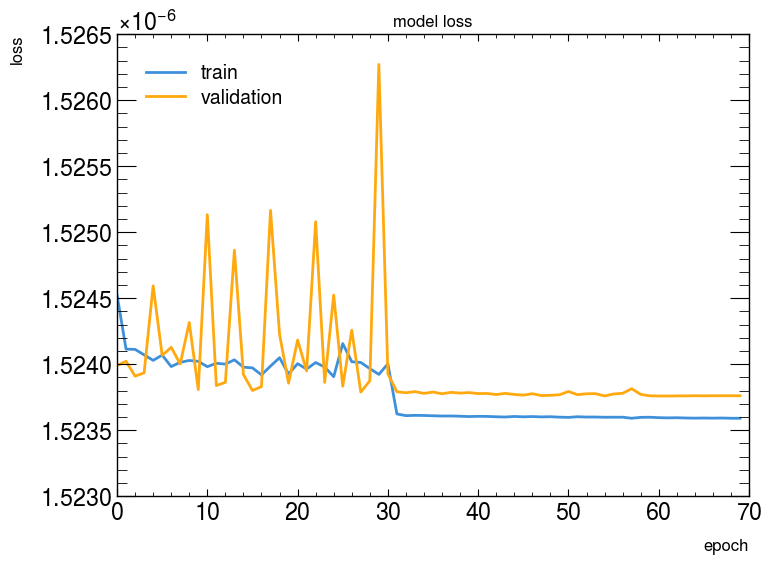

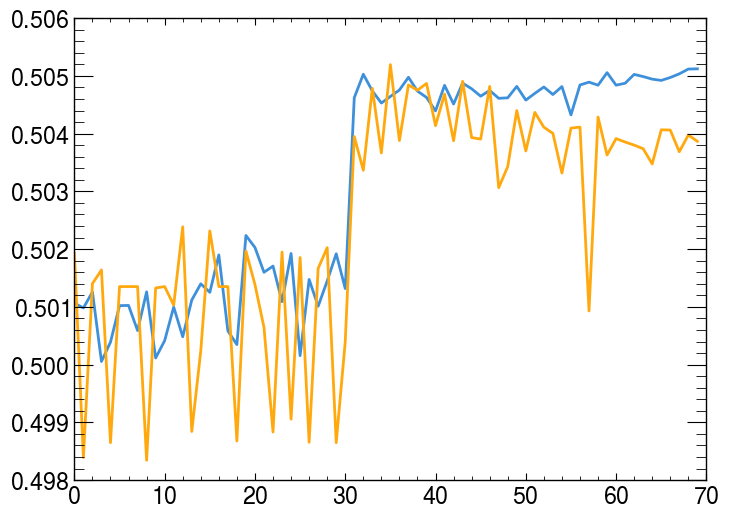

5687/5687 - 3s - 3s/epoch - 568us/step
22745/22745 - 14s - 14s/epoch - 597us/step
28432/28432 - 17s - 17s/epoch - 601us/step
The sum of PDFs is 0.5003456843401175
Sum of weights of class 0: 0.8000012898981631
Sum of weights of class 1: 0.8000004486759569
Using swish activation function
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 1000)              6000      
                                                                 
 dense_28 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_29 (Dense)            (None, 1)                 1001      
                                                                 
Total params: 1008001 (3.85 MB)
Trainable params: 1008001 (3.85 MB)
Non-trainable params: 0 (0.00 Byte)
___________________________________________________________

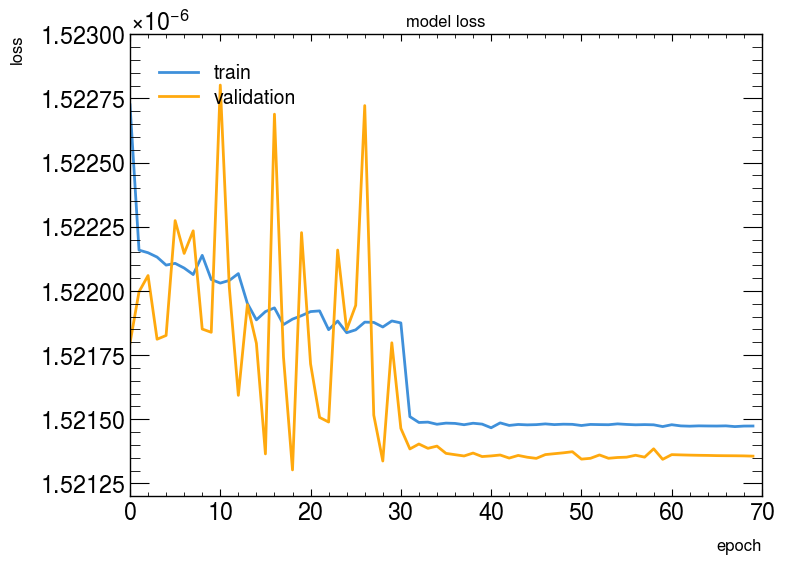

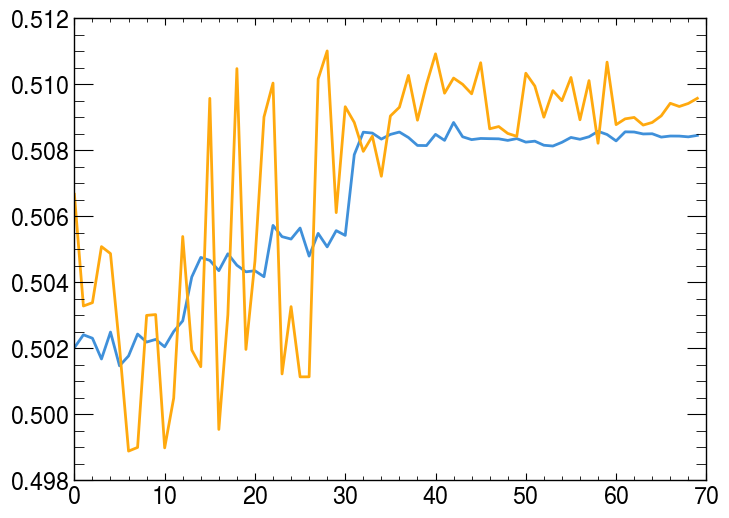

5694/5694 - 4s - 4s/epoch - 650us/step
22773/22773 - 13s - 13s/epoch - 574us/step
28466/28466 - 16s - 16s/epoch - 558us/step
The sum of PDFs is 0.4991852506367226
Nothing to train for single_top_t_chan in ttbar_scale uncertainty
Nothing to train for wjets in ttbar_scale uncertainty


<Figure size 800x600 with 0 Axes>

In [35]:
for process in labels_dict:
    
    for syst in dict_systs:

        if process not in dict_systs[syst]:
            print(f"Nothing to train for {process} in {syst} uncertainty")
            continue
        
        for direction in ['up', 'down']:

            # Train the density ratio NN
            NN_training_syst_process[process][syst][direction].train (   hidden_layers        = 2, 
                                                                         neurons              = 1000, 
                                                                         number_of_epochs     = 70, 
                                                                         batch_size           = 512, 
                                                                         learning_rate        = 0.1, 
                                                                         scalerType           = 'StandardScaler', 
                                                                         calibration          = False, 
                                                                         num_bins_cal         = 10, 
                                                                         callback             = True, 
                                                                         callback_patience    = 30, 
                                                                         callback_factor      = 0.01,
                                                                         verbose              = 0          )    
            
            NN_training_syst_process[process][syst][direction].test_normalization ( )    
            


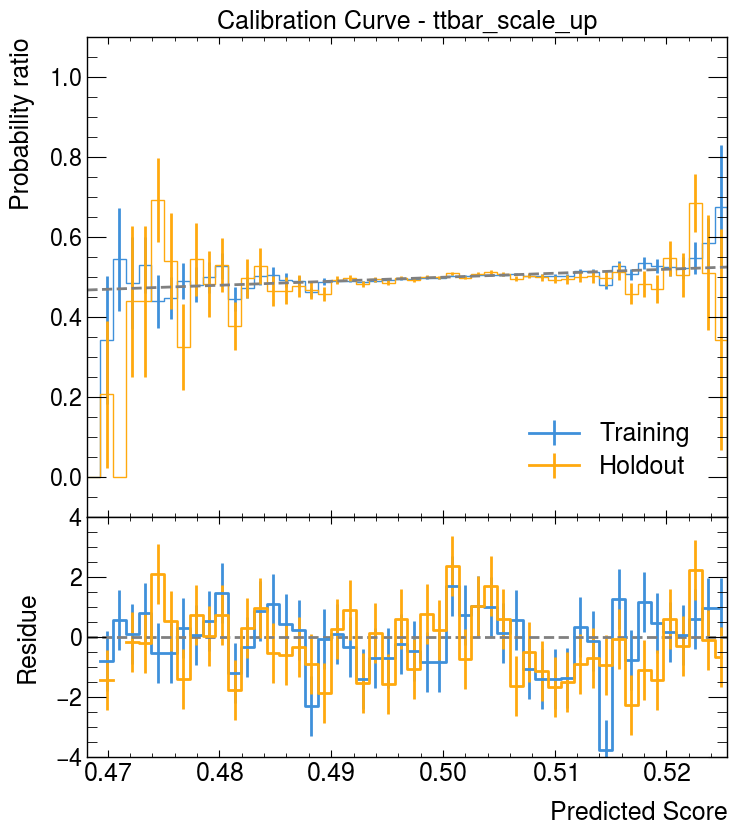

observable not recognized


<Figure size 800x600 with 0 Axes>

In [36]:
num_bins_cal = 50
NN_training_syst_process["ttbar"]["ttbar_scale"]["up"].make_calib_plots(nbins=num_bins_cal, observable='score')

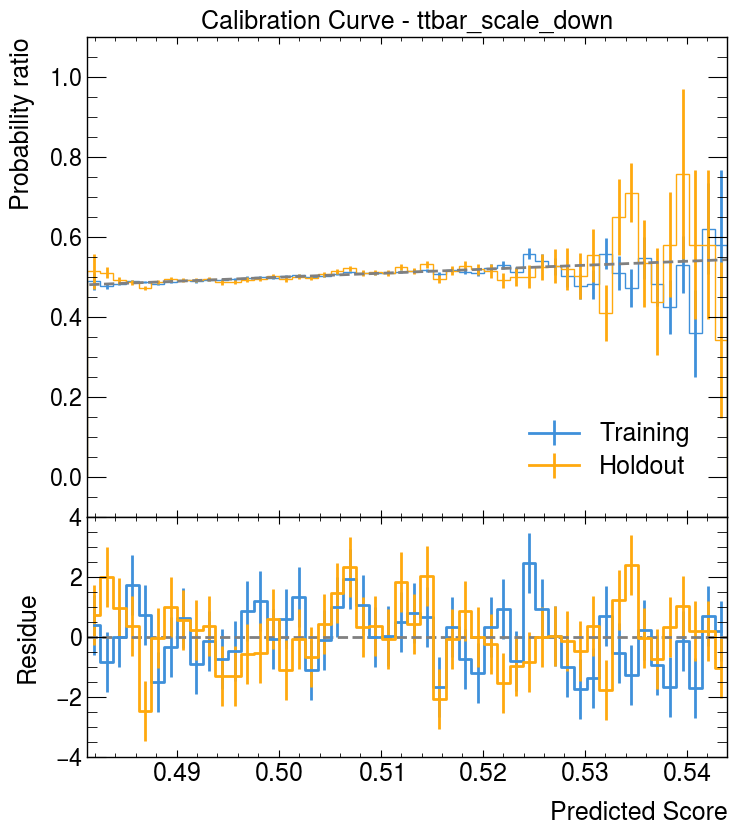

observable not recognized


<Figure size 800x600 with 0 Axes>

In [37]:
num_bins_cal = 50
NN_training_syst_process["ttbar"]["ttbar_scale"]["down"].make_calib_plots(nbins=num_bins_cal, observable='score')

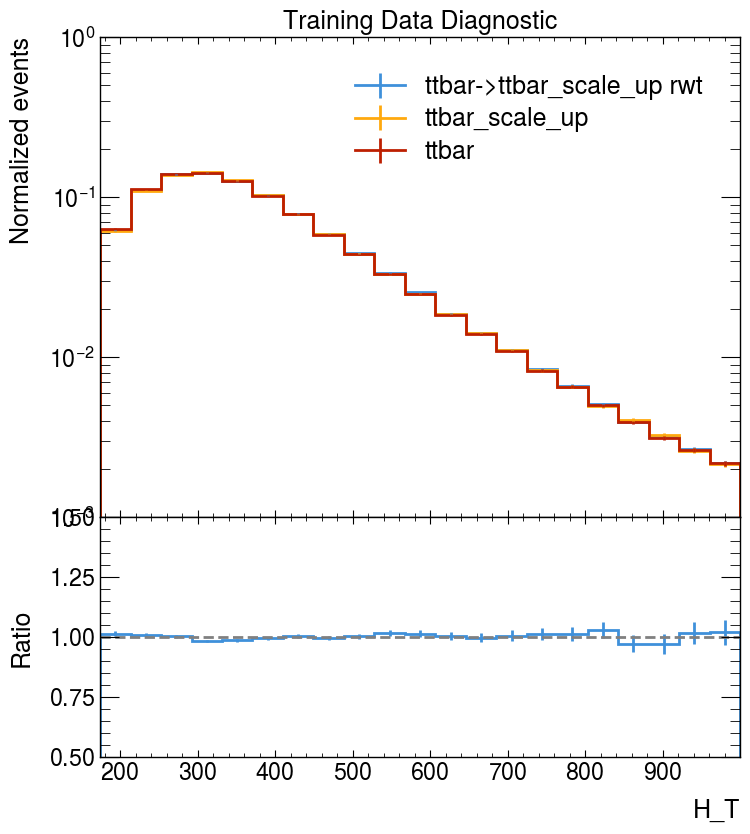

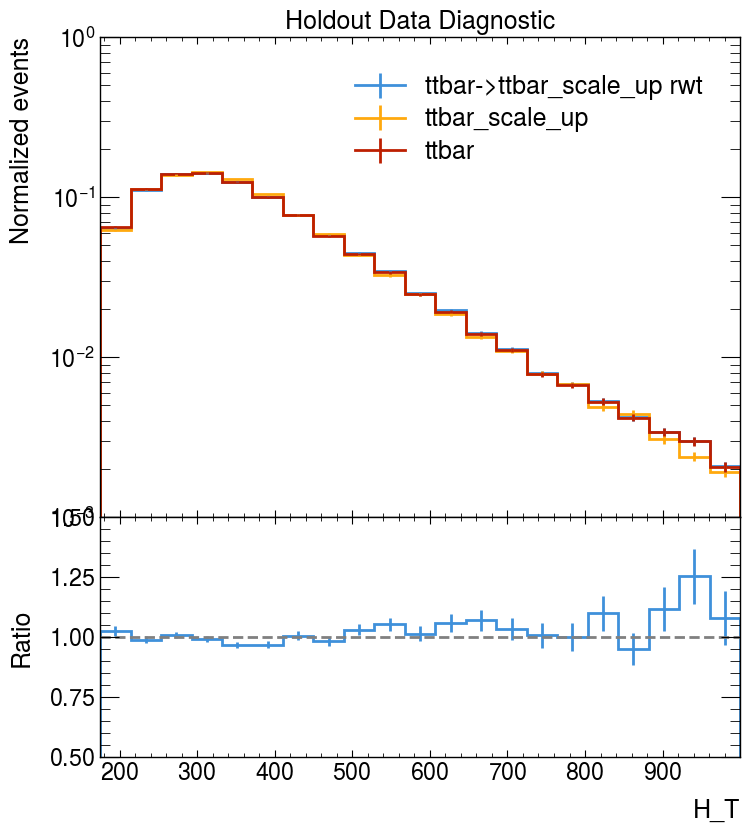

<Figure size 800x600 with 0 Axes>

In [38]:
variables_to_plot=['H_T'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["ttbar"]["ttbar_scale"]["up"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


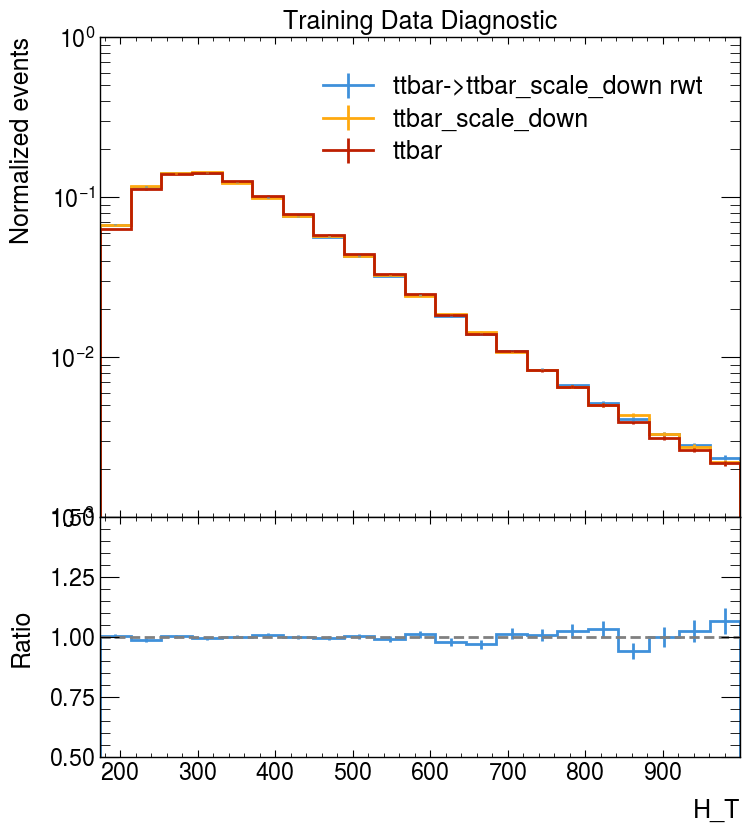

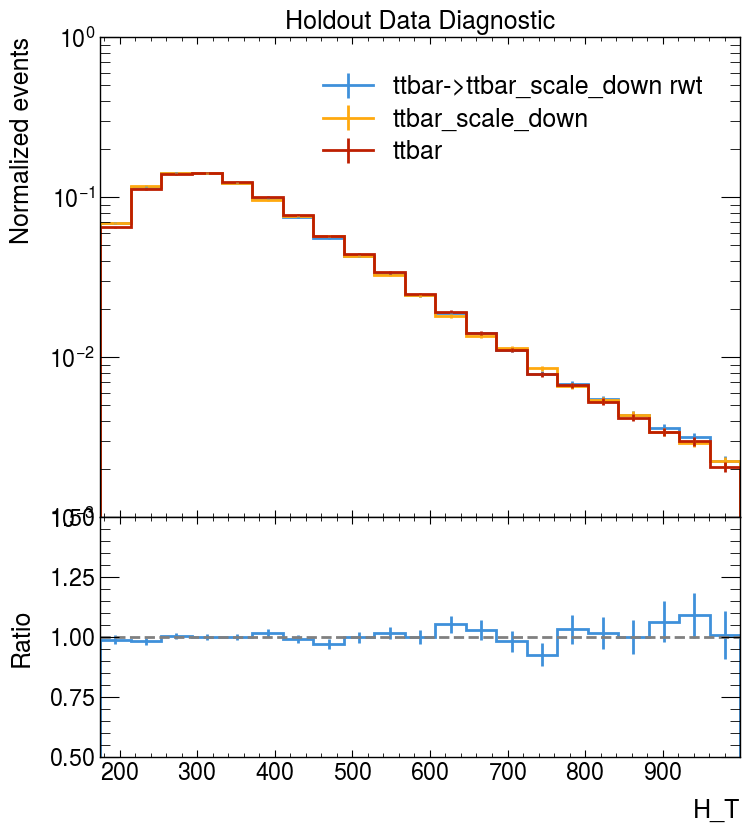

<Figure size 800x600 with 0 Axes>

In [39]:
variables_to_plot=['H_T'] # The 1D variable for reweighting closure
yscale_type='log'
num_bins_plotting=21

NN_training_syst_process["ttbar"]["ttbar_scale"]["down"].make_reweighted_plots(variables_to_plot, yscale_type, num_bins_plotting)


In [40]:
dataset_eval = pd.read_hdf(f"{saved_data}dataset_preselected_ttbar.h5", key="dataset", mode='r')

for process in labels_dict:
    
    for syst in dict_systs:

        if process not in dict_systs[syst]:
            print(f"Nothing to evaluate for {process} in {syst} uncertainty")
            continue
        
        for direction in ['up', 'down']:

            # Evaluate the density ratios p_alpha^\pm/p_nom for the nominal dataset
            NN_training_syst_process[process][syst][direction].evaluate_and_save_ratios(dataset_eval)


21173/21173 - 12s - 12s/epoch - 553us/step
21173/21173 - 11s - 11s/epoch - 537us/step
Nothing to evaluate for single_top_t_chan in ttbar_scale uncertainty
Nothing to evaluate for wjets in ttbar_scale uncertainty


In [41]:
# Save the systematic variation on total yields in the SR
nu_var_SR = {}
for process in labels_dict:

    mask_process = dataset_SR.type==process
    nu_var_SR[process] = {}
    
    for syst in dict_systs:

        nu_var_SR[process][syst] = {}
        
        for direction in ['up', 'down']:
            
            if process not in dict_systs[syst]:
                nu_var_SR[process][syst][direction] = 1.0
            else:
                mask_process_syst = (dataset_SR.syst_labels==syst+'_'+direction) & mask_process
                mask_nominal = (dataset_SR.syst_labels=='nominal') & mask_process
                nu_var_SR[process][syst][direction] = dataset_SR[mask_process_syst].weights.sum() / dataset_SR[mask_nominal].weights.sum()

In [42]:
# Save the Control Region variation histogram
with open(f"{saved_data}yield_SR_variations.pkl", "wb") as fp:
    pickle.dump(nu_var_SR, fp)